<a href="https://colab.research.google.com/github/shreya27tripathi/xception_autism/blob/main/xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import pandas as pd
import gc
import cv2
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

# from keras.applications.vgg16 import VGG16
from keras import layers
from keras.applications.xception import Xception
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import os

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = "/content/drive/MyDrive/AutismDataset/train"
test_dir = "/content/drive/MyDrive/AutismDataset/test"

In [27]:
# Getting 'Autistic' and 'Non-Autistic' train images from respective file names of train data
train_non_autistic = []
train_autistic = []
for i in os.listdir(train_dir):
    if 'Non_Autistic' in ("/content/drive/MyDrive/AutismDataset/train/{}".format(i)):
        train_non_autistic.append(("/content/drive/MyDrive/AutismDataset/train/{}".format(i)))
    else:
        train_autistic.append(("/content/drive/MyDrive/AutismDataset/train/{}".format(i)))

# Getting test images from test data file path
test_imgs = ["/content/drive/MyDrive/AutismDataset/test/{}".format(i) for i in os.listdir(test_dir)]


# Concatenate 'Autistic'  and 'Non-Autistic' images and shuffle them as train_images
train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)

# Remove the lists to save space
del train_autistic
del train_non_autistic
gc.collect()

6718

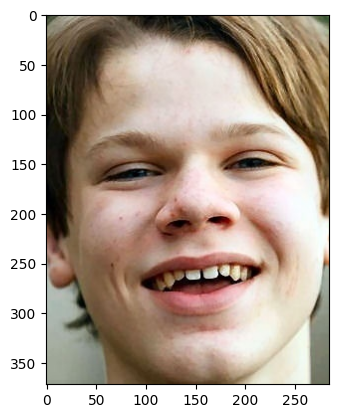

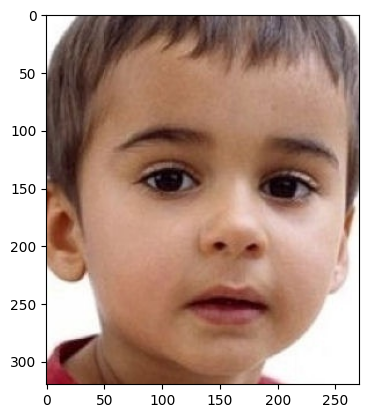

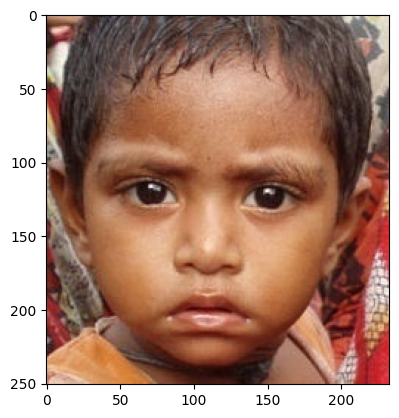

In [6]:
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [7]:
# Set the dimensions for images
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

def read_and_process_image(list_of_images):
    X = []
    y = []

    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)

    return X,y

In [9]:
# Get resized images and labels from train data
X_train, y_train = read_and_process_image(train_imgs)

# Delete train images to save space
# del train_imgs
gc.collect()

6871

Text(0.5, 1.0, 'Train image labels')

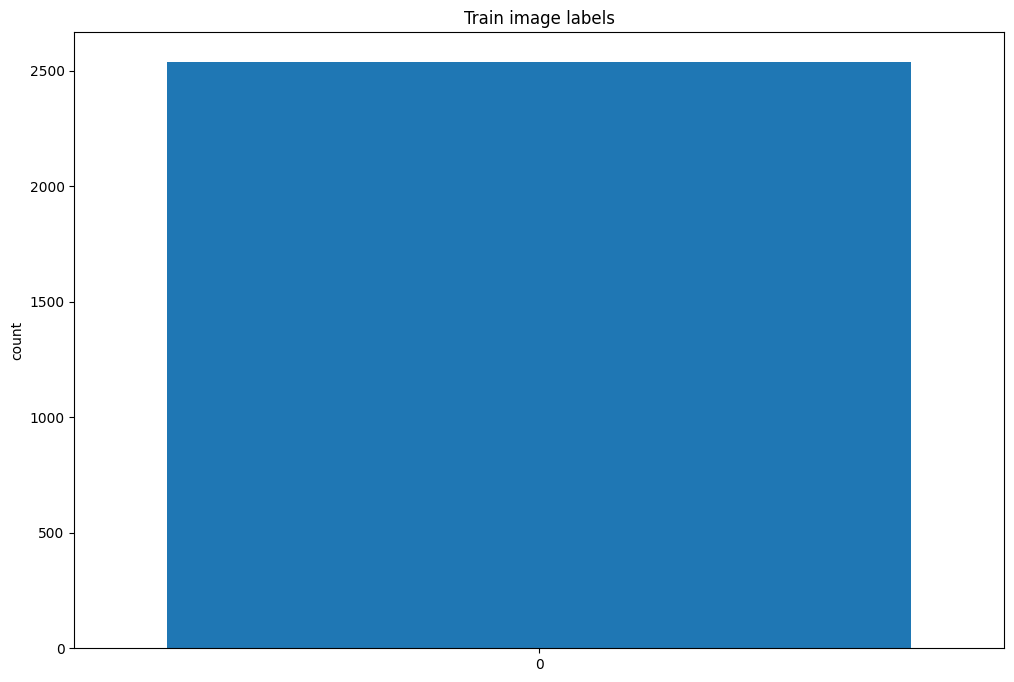

In [10]:
# Convert the lists to array
plt.figure(figsize=(12, 8))
X_train = np.array(X_train)
y_train = np.array(y_train)
sns.countplot(y_train, saturation=1)
plt.title("Train image labels")

In [11]:
# Shape of train images and labels
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 150, 150, 3)
Shape of train labels: (2540,)


In [12]:
# Repeat the above process for validation data to get val_images
val_autistic = "/content/drive/MyDrive/AutismDataset/valid/Autistic"
val_non_autistic = "/content/drive/MyDrive/AutismDataset/valid/Non_Autistic"
val_autistic_imgs = ["/content/drive/MyDrive/AutismDataset/valid/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = ["/content/drive/MyDrive/AutismDataset/valid/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

# Remove the lists to save space
del val_autistic_imgs
del val_non_autistic_imgs
gc.collect()

0

In [13]:
X_test, y_test = read_and_process_image(test_imgs)
X_val, y_val = read_and_process_image(val_imgs)
del train_imgs
del test_imgs
del val_imgs
gc.collect()

0

In [14]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=(150, 150, 3), pooling='avg')

83683744/83683744 [==============================] - 1s 0us/step


In [15]:
for layer in base_model.layers:
   layer.trainable = False

In [16]:
model = Sequential()
model.add(base_model)
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(units = 256 , activation = 'relu'))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22058409 (84.15 MB)
Trainable params: 1196

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
# Solo reescalado para datos de validación
val_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
BATCH_SIZE = 64
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
train_generator = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size = BATCH_SIZE)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

history = model.fit(train_generator,
                              epochs=10,
                              validation_data=val_generator,
                              callbacks=[early_stopping],
                              workers=8,
                              use_multiprocessing=False
                             )

Epoch 1/10
40/40 [==============================] - 310s 7s/step - loss: 0.6382 - accuracy: 0.6524 - val_loss: 0.5445 - val_accuracy: 0.7400
Epoch 2/10
40/40 [==============================] - 278s 7s/step - loss: 0.5989 - accuracy: 0.6909 - val_loss: 0.5725 - val_accuracy: 0.7000
Epoch 3/10
40/40 [==============================] - 275s 7s/step - loss: 0.5625 - accuracy: 0.7154 - val_loss: 0.5426 - val_accuracy: 0.7300
Epoch 4/10
40/40 [==============================] - 273s 7s/step - loss: 0.5554 - accuracy: 0.7122 - val_loss: 0.5319 - val_accuracy: 0.7400
Epoch 5/10
40/40 [==============================] - 279s 7s/step - loss: 0.5528 - accuracy: 0.7118 - val_loss: 0.5332 - val_accuracy: 0.7200
Epoch 6/10
40/40 [==============================] - 271s 7s/step - loss: 0.5420 - accuracy: 0.7323 - val_loss: 0.5437 - val_accuracy: 0.7400
Epoch 7/10
40/40 [==============================] - 271s 7s/step - loss: 0.5307 - accuracy: 0.7268 - val_loss: 0.5212 - val_accuracy: 0.7100
Epoch 8/10
40

In [21]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.638244,0.652362,0.544455,0.74
1,0.598911,0.690945,0.572475,0.70
2,0.562526,0.715354,0.542617,0.73
3,0.555441,0.712205,0.531886,0.74
4,0.552780,0.711811,0.533178,0.72
5,0.541962,0.732283,0.543653,0.74
6,0.530663,0.726772,0.521201,0.71
7,0.540642,0.732283,0.541630,0.73
8,0.522643,0.736614,0.518054,0.74
9,0.528693,0.733858,0.517882,0.75


Text(0.5, 1.0, 'Training and Validation Accuracy')

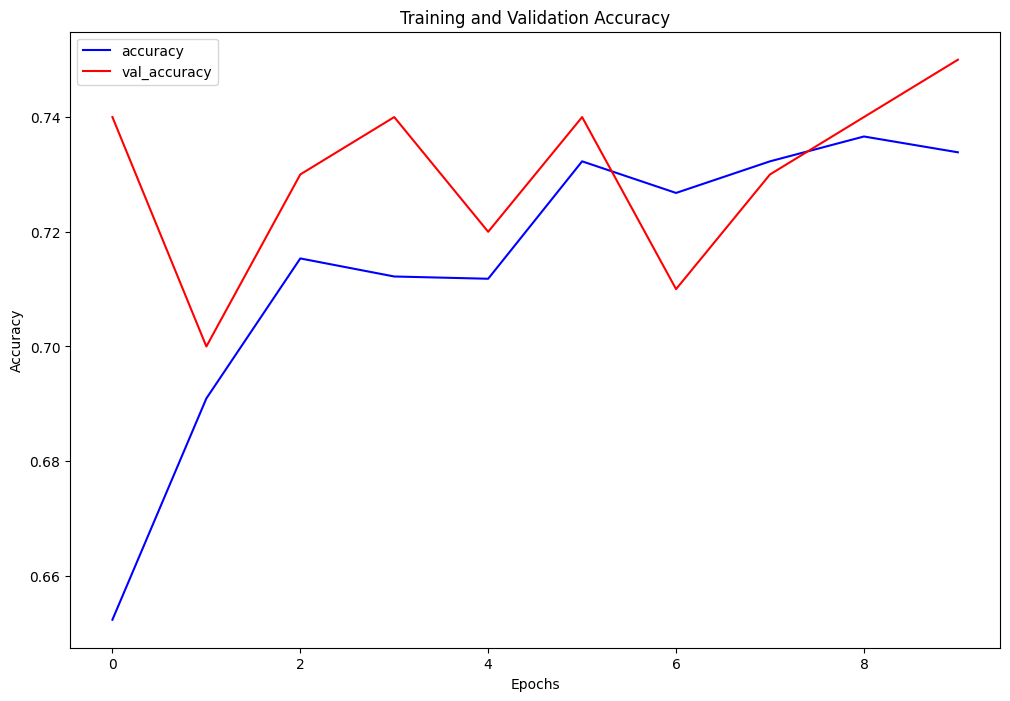

In [22]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["accuracy", "val_accuracy"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

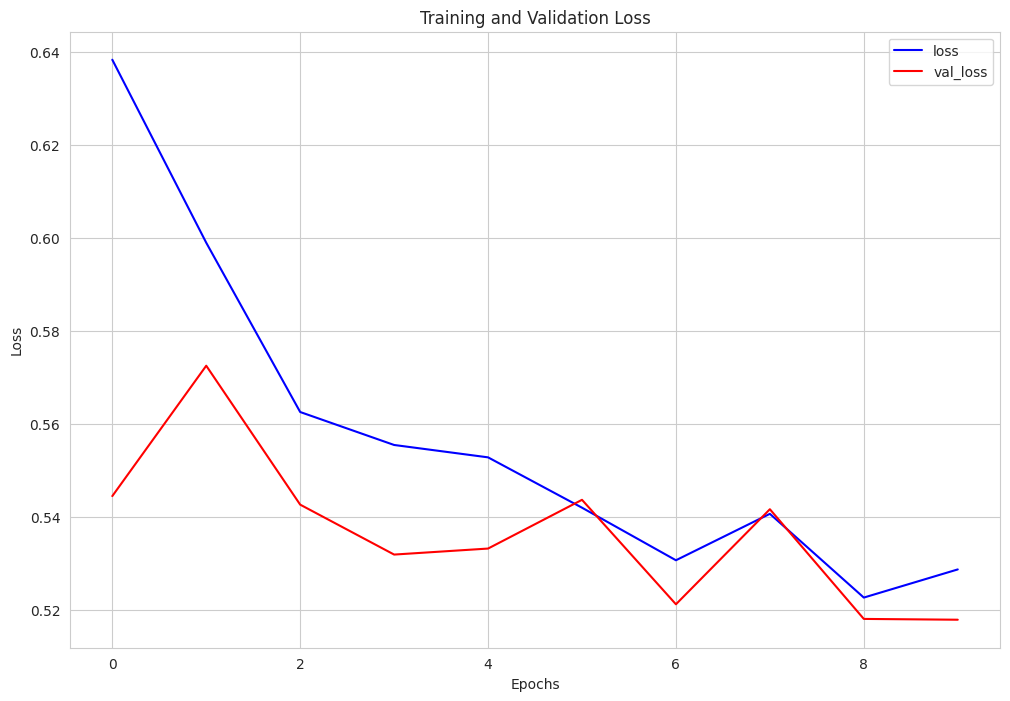

In [23]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

In [24]:
X = np.array(X_test)

In [25]:
pred = model.predict(X)
threshold = 0.5
predictions = np.where(pred > threshold, 1,0)

10/10 [==============================] - 45s 4s/step


In [28]:
test = pd.DataFrame(data = predictions, columns = ["predictions"])
test
test["filename"] = [os.path.basename(i) for i in test_imgs]
test["test_labels"] = y_test
test = test[["filename", "test_labels", "predictions"]]
test

,filename,test_labels,predictions
0,Autistic.48.jpg,1,1
1,Autistic.120.jpg,1,1
2,Autistic.87.jpg,1,1
3,Autistic.118.jpg,1,1
4,Autistic.115.jpg,1,1
...,...,...,...
295,Non_Autistic.92.jpg,0,1
296,Non_Autistic.35.jpg,0,1
297,Non_Autistic.51.jpg,0,1
298,Non_Autistic.24.jpg,0,1


In [29]:
model_accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy: {:.2f}%".format(model_accuracy * 100))

Model Accuracy: 50.00%


In [30]:
cl_report = classification_report(y_test, predictions)
print(cl_report)

              precision    recall  f1-score   support

           0       0.50      0.03      0.06       150
           1       0.50      0.97      0.66       150

    accuracy                           0.50       300
   macro avg       0.50      0.50      0.36       300
weighted avg       0.50      0.50      0.36       300



In [31]:
cn_matrix= confusion_matrix(y_test, predictions)
cn_matrix

array([[  5, 145],
       [  5, 145]])

Text(0.5, 1.0, 'Confusion Matrix')

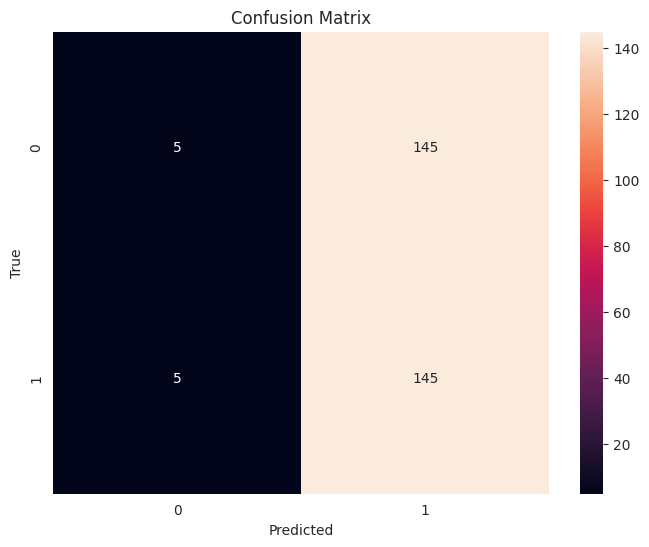

In [32]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix, annot=True,fmt="d")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")